In [17]:
import sys
!{sys.executable} -m pip install pandas

In [18]:
# Import the required modules
import glob
import time
import os
from collections import defaultdict
import fdsreader as fds
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import solve_ivp
from matplotlib import cm
from itertools import groupby, product
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline

In [19]:

class windODE:
    def __init__(
            self,
            directory,
            fds_input_location,
            t_span,
            numberStreakLines
    ):
        """

        :param directory: location of the fds output files
        :param fds_input_location: location of the fds input file
        :param t_span: time frame for ODE to run over

        :vars self.sim: fdsreader object
        :vars self.fds_input_location: fds_input_location
        :vars self.t_span: t_span
        :vars self.__directory: directory
        :vars self.__qFiles: list of all plot 3d output files
        :vars self.__timeList: list of all plot 3d time dumps
        :vars self.__voxalSize: resolution of each voxal
        :vars self.__maxVelocity: maximum velocity of any particle in the streamlines
        :vars self.startingpoints: list of all starting points to be used in the ODE

        """

        self.sim = fds.Simulation(directory)
        self.fds_input_location = fds_input_location
        self.t_span = t_span
        self.__numberOfStreakLines = numberStreakLines
        self.__directory = directory
        self.__qFiles = glob.glob(directory + "*.q")
        self.__timeList = np.array(self.sim.data_3d.times)
        self.__voxalSize = {}
        self.__maxVelocity = 0.0
        self.__maxRe = 0.0
        self.__REDict=defaultdict(lambda : [])
        self.startingpoints = []
        self.__meshBounds = self.sim.meshes[0]
        self.__meshExtent = self.sim.meshes[0].extent

        self.setVoxalSize()

    def setVoxalSize(self):
        """
        Calculates voxal size
        :return:
        """

        self.__voxalSize["vx"] = (self.__meshExtent.x_end - self.__meshExtent.x_start) / (
                self.__meshBounds.dimension["x"] - 1
        )
        self.__voxalSize["vz"] = (self.__meshExtent.z_end - self.__meshExtent.z_start) / (
                self.__meshBounds.dimension["z"] - 1
        )
        self.__voxalSize["vy"] = (self.__meshExtent.y_end - self.__meshExtent.y_start) / (
                self.__meshBounds.dimension["y"] - 1
        )
        return self
    def getVoxalSize(self):
        return self.__voxalSize

    def getPositionFromIndex(self,x):
        x_index = x[0]
        y_index = x[1]
        z_index = x[2]
        x_position = self.__meshExtent.x_start + x_index*self.__voxalSize["vx"]
        y_position = self.__meshExtent.y_start + y_index*self.__voxalSize["vy"]
        z_position = self.__meshExtent.z_start + z_index*self.__voxalSize["vz"]
        return [x_position,y_position,z_position]

    def getStartingPoints(self):

        """
        Creates a list of points  on the outer most voxals of OBSTS, one point per voxal
        :var X_Min_Value center point of minimum x voxal
        :var X_Max_Value center point of maximum x voxal
        :var Y_Min_Value center point of minimum y voxal
        :var Y_Max_Value center point of maximum y voxal

        :return:
        """
        X_Min_Value = (
                self.__meshExtent.x_start + self.__voxalSize["vx"] / 2.0
        )
        X_Max_Value = (
                self.__meshExtent.x_end - self.__voxalSize["vx"] / 2.0
        )
        Y_Min_Value = (
                self.__meshExtent.y_start + self.__voxalSize["vy"] / 2.0
        )
        Y_Max_Value = (
                self.__meshExtent.y_end - self.__voxalSize["vy"] / 2.0
        )
        with open(self.fds_input_location) as f:
            lines = f.readlines()

        lineCounter = 0
        while lineCounter < len(lines):
            current_line = lines[lineCounter]
            if current_line == "\n":
                lineCounter += 1
                continue
            while "/" not in lines[lineCounter]:
                lineCounter += 1
                current_line = current_line + lines[lineCounter]

            lineCounter += 1
            if "&OBST" not in current_line:
                continue
            mesh_line = current_line.replace("/", "").replace("\n", "")
            XB = [float(point) for point in mesh_line.split("XB=")[1].split(",")[:6]]

            if XB[0] <= X_Min_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )

            if XB[0] <= X_Max_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )
            if XB[2] <= Y_Min_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )
            if XB[2] <= Y_Max_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )

        return self

    def filterOutStreamsByLength(self):
        """
        This function removes all streamlines that total distance traveled is below a desired length.
        :return:
        """
        self.filteredTImeResults = {}

        self.distanceofWindStreams_index = defaultdict(lambda: [])
        allData = self.timeReasults
        for time in allData.keys():

            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            for i in range(numberofWindstreams):
                distanceofWindStream = 0
                for j in range(1, len(data[i]["y"][0])):
                    point1 = np.array(
                        (
                            data[i]["y"][0][j - 1],
                            data[i]["y"][1][j - 1],
                            data[i]["y"][2][j - 1],
                        )
                    )
                    point2 = np.array(
                        (data[i]["y"][0][j], data[i]["y"][1][j], data[i]["y"][2][j])
                    )
                    p1_p2_distance = np.linalg.norm(point1 - point2)
                    distanceofWindStream += p1_p2_distance

                if distanceofWindStream > np.min(list(self.__voxalSize.values())) * 2.0:
                    self.distanceofWindStreams_index[time].append(i)

    def startingPointsRibbon(self, starting_pont, ending_point, number_of_points):
        x_ = np.linspace(starting_pont[0], ending_point[0], number_of_points)
        y_ = np.linspace(starting_pont[1], ending_point[1], number_of_points)
        z_ = np.linspace(starting_pont[2], ending_point[2], number_of_points)
        points = np.stack((x_.flatten(), y_.flatten(), z_.flatten()), axis=1)

        self.startingpoints.extend(points)
        return self

    def runODE(self,time_step_index,reverse_integration=False):
        t_span = [
            min(self.__timeList[time_step_index:]),
            max(self.__timeList[time_step_index:]),
        ]
        current_results=[]

        if reverse_integration:
            t_span[1] = 0.0

        for startCounter in range(len(self.startingpoints)):
            y0 = self.startingpoints[startCounter]

            result_solve_ivp = solve_ivp(
                self.get_velocity, t_span, y0,
                # rtol=1E-4, atol=1E-6,
            )
            result_with_velocity = self.addVelocity(result_solve_ivp)
            current_result_max_vel = np.max(result_with_velocity["velocity"])
            if self.__maxVelocity < current_result_max_vel:
                print(
                    f"new max Velocity {current_result_max_vel} changed from {self.__maxVelocity}"
                )
                self.__maxVelocity = current_result_max_vel

            result_with_re = self.addReynoldsNumber(result_with_velocity)
            current_result_max_re = np.max(result_with_re["re"])
            self.__REDict[self.__timeList[time_step_index]].append(current_result_max_re)
            if self.__maxRe < current_result_max_re:
                print(
                    f"new max RE {current_result_max_re} changed from {self.__maxRe}"
                )
                self.__maxRe = current_result_max_re
            current_results.append(result_with_re)
        return current_results

    def StartODE(self, reverse_integration=True):

        self.timeReasults = {}
        for t_start in self.__timeList:
            if t_start > self.t_span[1] or t_start < self.t_span[0]:
                continue

            time_step_index = self.__GetClosestTimeStepIndex(t_start)

            all_results=self.runODE(time_step_index)
            if reverse_integration:
                backward = self.runODE(time_step_index,True)
                all_results= self.combineODEFrames(all_results,backward)
            self.timeReasults[t_start] = all_results

        return self

    def combineODEFrames(self, all_forward_data,all_backwards_data):
        return_values = all_backwards_data
        for i in range(len(all_backwards_data)):
            backwards_data = all_backwards_data[i]
            forward_data = all_forward_data[i]
            return_values[i]['t'] = backwards_data['t'][::-1]
            return_values[i]['y'][0] = backwards_data['y'][0][::-1]
            return_values[i]['y'][1] = backwards_data['y'][1][::-1]
            return_values[i]['y'][2] = backwards_data['y'][2][::-1]
            return_values[i]['velocity'] = backwards_data['velocity'][::-1] * -1
            return_values[i]['re'] = backwards_data['re'][::-1]


            return_values[i]['t']= np.concatenate((backwards_data['t'], forward_data['t'][1:]))

            y_=[np.concatenate((backwards_data['y'][0],forward_data['y'][0][1:])),
              np.concatenate((backwards_data['y'][1],forward_data['y'][1][1:])),
              np.concatenate((backwards_data['y'][2],forward_data['y'][2][1:]))]
            return_values[i]['y']=y_
            return_values[i]['velocity']=np.concatenate((backwards_data['velocity'],forward_data['velocity'][1:]))

            return_values[i]['re']=np.concatenate((backwards_data['re'], forward_data['re'][1:]))

        return return_values


    def write2bin(self, desired_directory, file_name_prefix):
        fileName = os.path.join(desired_directory, file_name_prefix)
        allData = self.timeReasults
        maxVel = self.__maxVelocity
        print(f"Max {maxVel}")
        for time in allData.keys():
            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            time_string = f"{time}".split(".")[1]
            with open(f"{fileName}_{int(time)}_{time_string}.binwind", "wb") as outfile:

                np.ndarray.tofile(np.array([maxVel], dtype=np.float32), outfile)
                np.ndarray.tofile(np.array([numberofWindstreams], dtype=int), outfile)
                np.ndarray.tofile(np.array(lengthofWindStreams, dtype=int), outfile)

                for i in range(numberofWindstreams):
                    currentStream = []
                    for j in range(len(data[i]["y"][0])):
                        currentStream.append(
                            [
                                data[i]["t"][j],
                                data[i]["velocity"][j],
                                data[i]["y"][0][j],
                                data[i]["y"][1][j],
                                data[i]["y"][2][j],
                            ]
                        )

                    np.ndarray.tofile(
                        np.array(currentStream, dtype=np.float32), outfile
                    )
                print(fileName, "saved")
        return self

    def get_velocity(self, t, x):

        counter = self.__GetClosestTimeStepIndex(t)
        plt_3d_data = self.sim.data_3d[counter]

        mesh = self.sim.meshes[0]
        # Select a quantity
        uvel_idx = plt_3d_data.get_quantity_index("U-VEL")
        vvel_idx = plt_3d_data.get_quantity_index("V-VEL")
        wvel_idx = plt_3d_data.get_quantity_index("W-VEL")
        index_values = self.get_index_values(x)
        u_vel_data = plt_3d_data[mesh].data[:, :, :, uvel_idx]
        u_velocity = u_vel_data[index_values[0], index_values[1], index_values[2]]
        v_vel_data = plt_3d_data[mesh].data[:, :, :, vvel_idx]
        v_velocity = v_vel_data[index_values[0], index_values[1], index_values[2]]
        w_vel_data = plt_3d_data[mesh].data[:, :, :, wvel_idx]
        w_velocity = w_vel_data[index_values[0], index_values[1], index_values[2]]

        return np.array([u_velocity, v_velocity, w_velocity])

    def get_index_values(self, x):
        x_index = (x[0] - self.__meshExtent.x_start) / self.__voxalSize["vx"]
        if 0 > x_index or x_index > self.__meshBounds.dimension["x"]:
            return np.array([0, 0, 0], dtype=int)
        y_index = (x[1] - self.__meshExtent.y_start) / self.__voxalSize["vy"]
        if 0 > y_index or y_index > self.__meshBounds.dimension["y"]:
            return np.array([0, 0, 0], dtype=int)
        z_index = (x[2] - self.__meshExtent.z_start) / self.__voxalSize["vz"]
        if 0 > z_index or z_index > self.__meshBounds.dimension["z"]:
            return np.array([0, 0, 0], dtype=int)
        return np.array([x_index, y_index, z_index], dtype=int)

    def addReynoldsNumber(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allRe = []  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        for i in range(len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            currentTime = allTimes[i]
            allRe.append(self.__GetReynoldsNumber(currentPosition, currentTime))

        oneDataSet["re"] = np.array(allRe)
        return oneDataSet

    def addVelocity(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allSpeeds = [0.0]  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        previousPosition = np.array(
            [allPositions[0][0], allPositions[1][0], allPositions[2][0]]
        )
        for i in range(1, len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            deltaTime = allTimes[i] - allTimes[i - 1]
            squared_dist = np.sum((currentPosition - previousPosition) ** 2, axis=0)
            dist = np.sqrt(squared_dist)
            if dist ==0.0 or deltaTime ==0.0:
                speed=0.0
            else:
                speed = dist / deltaTime
            allSpeeds.append(speed)
            previousPosition = currentPosition

        oneDataSet["velocity"] = np.array(allSpeeds)
        return oneDataSet

    def drawPlot(self):
        for time in self.distanceofWindStreams_index.keys():
            data = self.timeReasults[time]
            maxRE= np.max(np.array(self.__REDict[time]))
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(1, 1, 1, projection="3d")
            print(time)
            print(self.distanceofWindStreams_index[time])
            for i in self.distanceofWindStreams_index[time]:
                print( data[i]["y"][0][:])
                x = data[i]["y"][0][:]
                y = data[i]["y"][1][:]
                z = data[i]["y"][2][:]
                re = data[i]["re"][:]

                temp =np.max(re)/maxRE
                ax.plot(x, y, z,  c=cm.viridis(temp))

            plt.show()


    def __GetClosestTimeStepIndex(self, t):
        closest_timeStep_value = min(self.__timeList, key=lambda x: abs(x - t))
        closest_timeStep_index = np.where(self.__timeList == closest_timeStep_value)[0][0]
        return int(closest_timeStep_index)

    def __GetReynoldsMatrix(self, t):
        time_step_index = self.__GetClosestTimeStepIndex(t)
        plt_3d_data = self.sim.data_3d[time_step_index]

        mesh = self.sim.meshes[0]
        # Select a quantity
        try:
            dxeta_idx = plt_3d_data.get_quantity_index("dx/eta")
        except:
            print("dx/eta plot 3d data ot found ")
            return []

        re_data = plt_3d_data[mesh].data[:, :, :, dxeta_idx]

        return re_data

    def __GetReynoldsNumber(self, x, t):
        re_data = self.__GetReynoldsMatrix(t)
        if len(re_data)==0:
            return

        index_values = self.get_index_values(x)
        re_value = re_data[index_values[0], index_values[1], index_values[2]]

        return re_value

    def EvaluateReynoldsValues(self):
        values = defaultdict(lambda : 0)
        for t in self.__timeList[3:10]:
            current_Re_values = self.__GetReynoldsMatrix(t)
            flatten_values =flatten_values_sorted  = np.array(current_Re_values,dtype=np.float64).flatten()
            flatten_values_sorted= list(np.sort(flatten_values_sorted))
            Re_percentile_min = np.percentile(flatten_values,86.5)
            ranking = {}
            for i in range(len(flatten_values_sorted)):
                ranking[flatten_values[i]]=i

            for i in range(current_Re_values.shape[0]):
                for j in range(current_Re_values.shape[1]):
                    for k in range(current_Re_values.shape[2]):
                        if current_Re_values[i,j,k] >=Re_percentile_min:
                            values[f"{i},{j},{k}"] += current_Re_values[i,j,k]

        print(np.max(list(values.values())))
        fig = plt.figure(figsize=(10, 7))
        ax = plt.axes(projection="3d")
        max_value = np.percentile(list(values.values()),70)
        x=[]
        y=[]
        z=[]
        c=[]
        for key in list(values.keys()):
            if values[key]< max_value:
                continue
            x_k,y_k,z_k = key.split(',')
            x.append(int(x_k))
            y.append(int(y_k))
            z.append(int(z_k))
            value = float(values[key])
            c.append(value)

        # Creating color map
        my_cmap = plt.get_cmap('viridis')

        scatter_plot=ax.scatter3D(x,y,z,c=c,cmap=my_cmap)

        plt.colorbar(scatter_plot)

        plt.show()

        highest_re_Points = []
        c_sorted = sorted(c)
        for i in range(len(c)):
            highest_re_Points.append(c.index(c_sorted[i]))

        fig = plt.figure(figsize=(10, 7))
        ax = plt.axes(projection="3d")
        x_1 = []
        y_1 = []
        z_1 = []
        c_1 = []
        for key in highest_re_Points[self.__numberOfStreakLines*-1:]:
            x_1.append(x[key])
            y_1.append(y[key])
            z_1.append(z[key])
            value = float(c[key])
            c_1.append(value)

        # Creating color map
        my_cmap = plt.get_cmap('viridis')
        scatter_plot = ax.scatter3D(x_1, y_1, z_1, c=c_1, cmap=my_cmap)
        plt.colorbar(scatter_plot)
        plt.show()

        points_of_interest_index = [ [x_1[i],y_1[i],z_1[i]] for i in range(len(x_1))]
        points_of_interest_position = [ self.getPositionFromIndex([x_1[i],y_1[i],z_1[i]]) for i in range(len(x_1))]
        for i in range(len(points_of_interest_position)):
            print(points_of_interest_index[i],points_of_interest_position[i])

        self.startingpoints.extend(points_of_interest_position)


    def getDataFromTime(self,t):
        if t in self.timeReasults.keys():
            return self.timeReasults[t]
        return []

    def getMaxRE(self):
        return self.__maxRe

    def getReynoldsMatrix(self,t):
        return self.__GetReynoldsMatrix(t)
    def getTimeList(self):
        return self.__timeList



In [20]:



fds_loc = "/home/trent/Trunk/Trunk/Trunk.fds"
dir = "/home/trent/Trunk/FireTime"
# fds_loc = "/home/kl3pt0/Trunk/Trunk/Trunk.fds"
# dir = "/home/kl3pt0/Trunk/Fire"
#
# fds_loc = "E:\Trunk\Trunk\Trunk\Trunk.fds"
# dir = "E:\Trunk\Trunk\\Fire\\"

t_span = [15,16]
start_time = time.perf_counter()
app = windODE(dir, fds_loc, t_span,100)
# app.EvaluateReynoldsValues()


# app.getStartingPoints()
# app.startingPointsRibbon([19, 1, 3.5], [1, 19, 3.5], 40)
# app.startingpoints = [[10,10,3]]
# app.StartODE(reverse_integration=True)
#
# app.filterOutStreamsByLength()
# app.write2bin("data","temp")

print(f"Total Time {time.perf_counter()-start_time:0.4f}")
# app.drawPlot()
print()

Total Time 0.0885



In [21]:
def getAverageREOverTime(app,t_start,t_end):

    allTimelist = app.getTimeList()
    filteredTimeList = allTimelist[allTimelist>=t_start]
    filteredTimeList = filteredTimeList[filteredTimeList<=t_end]
    reAverageMatrix = app.getReynoldsMatrix(filteredTimeList[0])
    for i in range(1,len(filteredTimeList)):
        reAverageMatrix = reAverageMatrix + app.getReynoldsMatrix(filteredTimeList[i])
    reAverageMatrix = reAverageMatrix/len(filteredTimeList)
    return np.array(reAverageMatrix)

In [22]:
def getMeanPeaksandSTD(reMatrix,n_bins):
    dataFlatten = reMatrix.flatten()
    dataNoZero = dataFlatten[dataFlatten>0.0]
    print(f"Min non Zero Value {np.min(dataNoZero)}")
    dataMean = np.mean(dataNoZero)
    dataStd = np.std(dataNoZero)
    dataSig2 = dataMean+ 2.0*dataStd
    dataSigNeg3 = dataMean- 3.0*dataStd
    print(f"Standard Dev {dataStd} Mean {dataMean}  2-sigma {dataSig2}")




    fig, ax = plt.subplots(figsize=(12, 6))

    plt.title(f"{n_bins} Bins without Zero Values")
    plt.xlim([-10,np.max(testData)])

    n,bins,patches=plt.hist(dataNoZero, bins=n_bins)

    peaks, _ = find_peaks(n,distance=15)
    print(bins[peaks])
    print(peaks)
    plt.axvline(dataMean, color='k', linestyle='dashed', linewidth=1, label="Mean")
    plt.axvline(dataSig2, color='r', linestyle='dashed', linewidth=1,label="2 Sigma")
    plt.axvline(dataSigNeg3, color='r', linestyle='dashed', linewidth=1,label="Negative 3 Sigma")
    min_ylim, max_ylim = plt.ylim()
    plt.text(dataMean*1.05, max_ylim*0.9, 'Mean: {:.2f}'.format(dataMean))
    plt.text((dataSigNeg3)*1.05, max_ylim*0.9, '-3 Sigma: {:.2f}'.format(dataSigNeg3))
    plt.text((dataSig2)*1.05, max_ylim*0.9, '2 Sigma: {:.2f}'.format(dataSig2))
    ax.legend()
    for patch_i in range(len(patches)):
        if bins[patch_i]<dataSig2:
            patches[patch_i].set_fc("xkcd:baby poop green")
        if bins[patch_i]<dataMean:
            patches[patch_i].set_fc("blue")
        if patch_i in peaks:
            patches[patch_i].set_fc("green")
        if bins[patch_i]>= dataSig2:
                patches[patch_i].set_fc("red")
    plt.show()
    returnDict = {'n':n,
                 'bins':bins,
                 'patches': patches,
                 'peaks': peaks,
                 'mean': dataMean,
                  'std': dataStd,
                 'sigmaTwo':dataSig2,
                 'sigmaNegThree':dataSigNeg3}
    return returnDict 

Min non Zero Value 44.210394064585365
Standard Dev 157.49606911276345 Mean 666.6198743488991  2-sigma 981.612012574426
[67.01979997913043 158.25742363731067 244.9331661125819 363.5420768682162
 454.7797005263965 536.8935618187586 632.6930666598479 705.6831655863921
 947.4628682805698 1034.138610755841 1129.9381155969304 1207.4900957063835
 1275.9183134500188 1353.4702935594719 1444.707917217652
 1522.2598973271054 1604.3737586194675 1681.9257387289208
 1754.9158376554649]
[  5  25  44  70  90 108 129 145 198 217 238 255 270 287 307 324 342 359
 375]


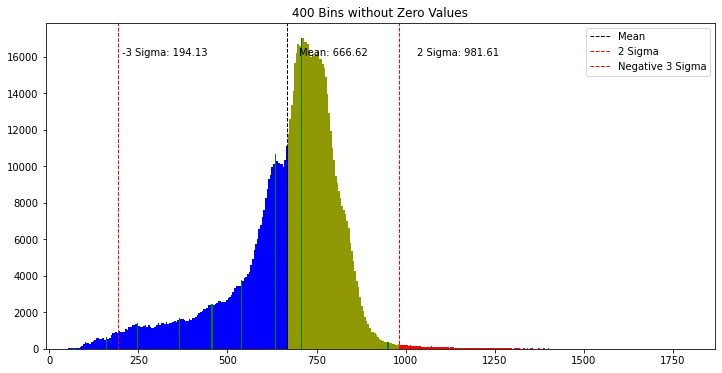

In [23]:
t_start = 0
t_end= 60

testData = getAverageREOverTime(app,t_start,t_end)


plotInfo = getMeanPeaksandSTD(reMatrix=testData,n_bins=400)

In [24]:
def plotPointsInRERange(plotRange,plotInfo):
    bins = plotInfo['bins']
    print(bins[plotInfo['peaks']])
    n = plotInfo['n']


    print(testData.shape)
    print(f"Points between {plotRange[0]} and {plotRange[1]}")
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection="3d")
    x_1 = []
    y_1 = []
    z_1 = []
    c_1 = []
    for x_i in range(testData.shape[0]):
        for y_i in range(testData.shape[1]):
            for z_i in range(testData.shape[2]):
                if (plotRange[0]<testData[x_i,y_i,z_i]):
                    if plotRange[1] is None or testData[x_i,y_i,z_i]<=plotRange[1] :

                        x_1.append(x_i)
                        y_1.append(y_i)
                        z_1.append(z_i)
                        c_1.append(testData[x_i,y_i,z_i])

    # Creating color map
    my_cmap = plt.get_cmap('viridis')
    scatter_plot = ax.scatter3D(x_1, y_1, z_1, c=c_1, cmap=my_cmap)
    ax.set_zlim(0,100)
    ax.set_ylim(0,100)
    ax.set_xlim(0,100)
    plt.colorbar(scatter_plot)
    plt.show()

    indexValues = [x_1,y_1,z_1,c_1]
    return np.array([app.getPositionFromIndex([indexValues[0][i],indexValues[1][i],indexValues[2][i]]) for i in range(len(indexValues[0]))])

[67.01979997913043 158.25742363731067 244.9331661125819 363.5420768682162
 454.7797005263965 536.8935618187586 632.6930666598479 705.6831655863921
 947.4628682805698 1034.138610755841 1129.9381155969304 1207.4900957063835
 1275.9183134500188 1353.4702935594719 1444.707917217652
 1522.2598973271054 1604.3737586194675 1681.9257387289208
 1754.9158376554649]
(101, 101, 101)
Points between 824.1159434616625 and 981.612012574426


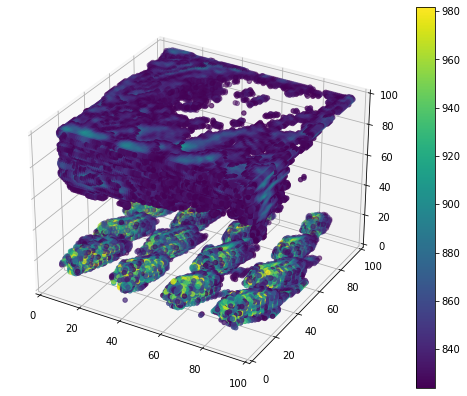

[67.01979997913043 158.25742363731067 244.9331661125819 363.5420768682162
 454.7797005263965 536.8935618187586 632.6930666598479 705.6831655863921
 947.4628682805698 1034.138610755841 1129.9381155969304 1207.4900957063835
 1275.9183134500188 1353.4702935594719 1444.707917217652
 1522.2598973271054 1604.3737586194675 1681.9257387289208
 1754.9158376554649]
(101, 101, 101)
Points between 981.612012574426 and None


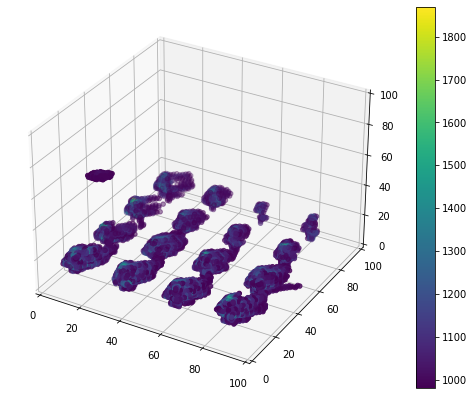

In [25]:
lamFlowIndex = plotPointsInRERange([plotInfo['mean']+plotInfo['std'],plotInfo['sigmaTwo']],plotInfo)
turbFlowIndex = plotPointsInRERange([plotInfo['sigmaTwo'],None],plotInfo)

In [26]:

def getStartingPositions(flowPostions):
    Z=pd.DataFrame(np.array(flowPostions))

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    i=132
    KMean= KMeans(n_clusters=i,)
    KMean.fit(Z)
    label=KMean.predict(Z)



    print(f'Silhouette Score(n={i}): {silhouette_score(Z, label)}')

    ax.scatter(flowPostions.T[0],flowPostions.T[1],flowPostions.T[2],c=label )
    closest, _ = pairwise_distances_argmin_min(KMean.cluster_centers_, Z)



    plt.show()
    print(label)
    return [[flowPostions.T[0][c],flowPostions.T[1][c],flowPostions.T[2][c]] for c in closest]

Silhouette Score(n=132): 0.2850251822236437


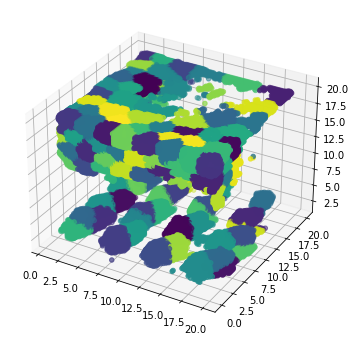

[ 22 113 113 ...  95  95  95]


In [27]:
startingPositions=getStartingPositions(lamFlowIndex)

Silhouette Score(n=132): 0.3361111617864174


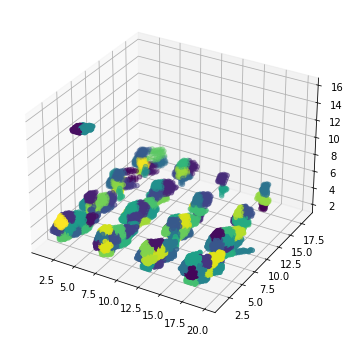

[ 26 111 111 ...  56  56  56]


In [28]:
startingPositions2=getStartingPositions(turbFlowIndex)

In [29]:
for i in startingPositions:
    startingPositions2.append(i)

new max Velocity 3.0152578934090086 changed from 0.0
new max RE 1794.15771484375 changed from 0.0
new max Velocity 9.290244072625514 changed from 3.0152578934090086
new max Velocity 10.021062053691205 changed from 9.290244072625514
new max Velocity 10.027959915071083 changed from 10.021062053691205
new max Velocity 11.383831570779593 changed from 10.027959915071083
new max Velocity 11.445714282289918 changed from 11.383831570779593
new max RE 2102.9140625 changed from 1794.15771484375
new max RE 2223.7177734375 changed from 2102.9140625
264
[58, 56, 38, 57, 40, 38, 66, 77, 60, 41, 71, 42, 49, 49, 47, 66, 89, 64, 46, 56, 44, 56, 50, 52, 65, 66, 70, 38, 38, 50, 48, 57, 61, 38, 47, 39, 51, 41, 35, 81, 55, 51, 60, 118, 44, 51, 49, 34, 89, 79, 55, 67, 59, 48, 48, 60, 17, 53, 63, 42, 42, 38, 40, 50, 62, 55, 84, 66, 39, 49, 62, 61, 62, 72, 42, 78, 58, 63, 57, 51, 60, 54, 49, 119, 83, 41, 35, 41, 67, 85, 70, 71, 35, 66, 62, 68, 51, 61, 39, 50, 40, 68, 33, 61, 48, 74, 49, 55, 53, 36, 62, 71, 52

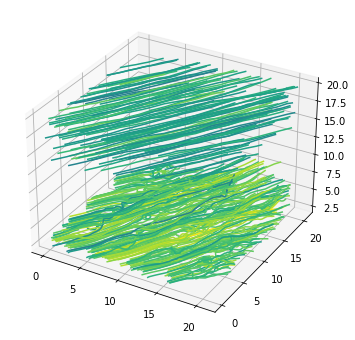

15.5
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

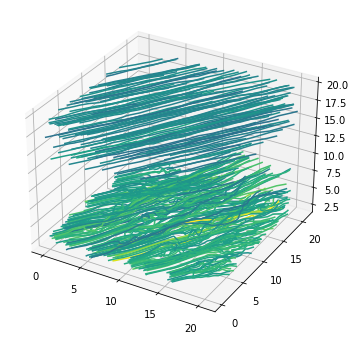

16.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

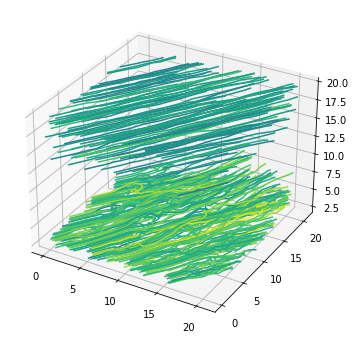

In [30]:




app.startingpoints = startingPositions2
app.StartODE(reverse_integration=True)


app.filterOutStreamsByLength()
app.drawPlot()
print()


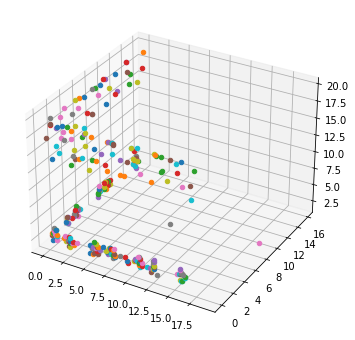

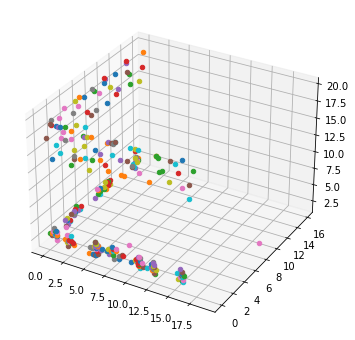

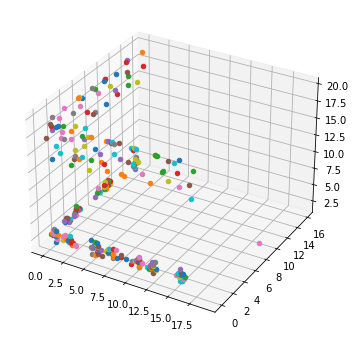

In [31]:
all_startingpoints = {}
for time in app.distanceofWindStreams_index.keys():
    all_startingpoints[time]=[]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    data = app.timeReasults[time]
    for i in app.distanceofWindStreams_index[time]:

        x = data[i]["y"][0][0]
        y = data[i]["y"][1][0]
        z = data[i]["y"][2][0]
        all_startingpoints[time].append([x,y,z])

        ax.scatter(x, y, z, )
    plt.show()
    

In [32]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline

15.0
Silhouette Score(n=100): 0.40166636368662556


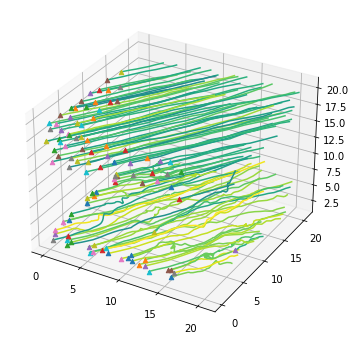

15.5
Silhouette Score(n=100): 0.3900352295592877


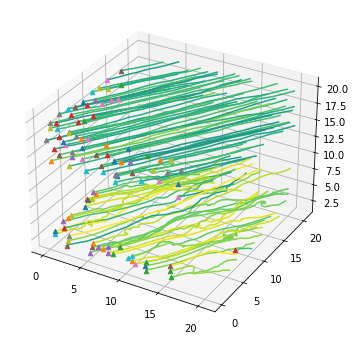

16.0
Silhouette Score(n=100): 0.3885158212449475


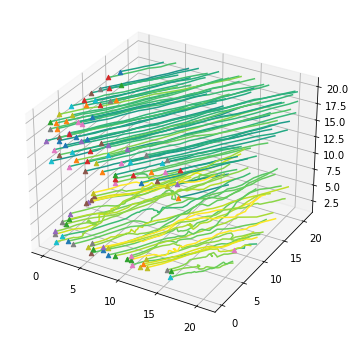

In [33]:
for t in all_startingpoints.keys():
    Z=pd.DataFrame(all_startingpoints[t])
    print(t)

    i=100
    KMean= KMeans(n_clusters=i)
    KMean.fit(Z)
    label=KMean.predict(Z)



    print(f'Silhouette Score(n={i}): {silhouette_score(Z, label)}')

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
#     ax.scatter3D(Z[0],Z[1],Z[2],c=label/i )
    closest, _ = pairwise_distances_argmin_min(KMean.cluster_centers_, Z)
    data = app.timeReasults[t]
    for c in closest:
        ax.scatter3D(Z[0][c],Z[1][c],Z[2][c],marker='^')


        x = data[c]["y"][0][:]
        y = data[c]["y"][1][:]
        z = data[c]["y"][2][:]
        re = data[c]["re"][:]

        temp =np.max(re)/1600.
        
        ax.plot(x, y, z,  c=cm.viridis(temp))
    
    plt.show()


In [34]:

for time in app.distanceofWindStreams_index.keys():
    data = self.timeReasults[time]
    maxRE= np.max(np.array(self.__REDict[time]))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    for i in self.distanceofWindStreams_index[time]:

        x = data[i]["y"][0][:]
        y = data[i]["y"][1][:]
        z = data[i]["y"][2][:]
        re = data[i]["re"][:]

        temp =np.max(re)/maxRE
        ax.plot(x, y, z,  c=cm.viridis(temp))
    plt.show()

NameError: name 'self' is not defined

### The Reynolds number is defined as

    Re = uL/ν = ρuL/μ 

where:

    ρ is the density of the fluid (SI units: kg/m3)
    u is the flow speed (m/s)
    L is a characteristic linear dimension (m) (see the below sections of this article for examples)
    μ is the dynamic viscosity of the fluid (Pa·s or N·s/m2 or kg/(m·s))
    ν is the kinematic viscosity of the fluid (m2/s).

### The Dynamic viscocity coefficient is defined as

    μ = μo*(a/b)*(T/To)3/2

    a = 0.555To + C
    b = 0.555T + C

where

    μ  = viscosity in centipoise at input temperature T    
    μ0 = reference viscosity in centipoise at reference temperature To 0.01827
    T   = input temperature in degrees Rankine
    T0 = reference temperature in degrees Rankine 524.07
    C  = Sutherland's constant  = 120